In [2]:
from prophet import Prophet
import pandas as pd

In [12]:
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.894325,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,73.175926,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.759003,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,73.412132,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,74.593040,132079200


In [13]:
df = df[['Date', 'Close']]
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df.head()

,ds,y
0,2020-01-02,75.087502
1,2020-01-03,74.357498
2,2020-01-06,74.949997
3,2020-01-07,74.597504
4,2020-01-08,75.797501


In [14]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/development/python/DSCC-FP-MVP/.venv/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.39373
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1360.01     0.0107973       407.696      0.2609      0.5242      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195        1377.6   0.000123191       97.9215   1.216e-06       0.001      267  LS failed, Hessian reset 
     199       1378.14     0.0166329       125.478           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1384.92    0.00404172        168.69           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1389.14     0.0116615       272.838      0.6683      0.6683      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     427       1390.85   0.000180788    

In [15]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
864,2022-12-26
865,2022-12-27
866,2022-12-28
867,2022-12-29
868,2022-12-30


In [16]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/home/development/python/DSCC-FP-MVP/.venv/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/development/python/DSCC-FP-MVP/.venv/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
864,2022-12-26,229.057858,177.882228,280.449665
865,2022-12-27,229.759785,175.650258,279.997520
866,2022-12-28,230.000652,177.710225,281.179829
867,2022-12-29,230.047054,177.077766,281.078240
868,2022-12-30,229.722102,176.274784,280.487888


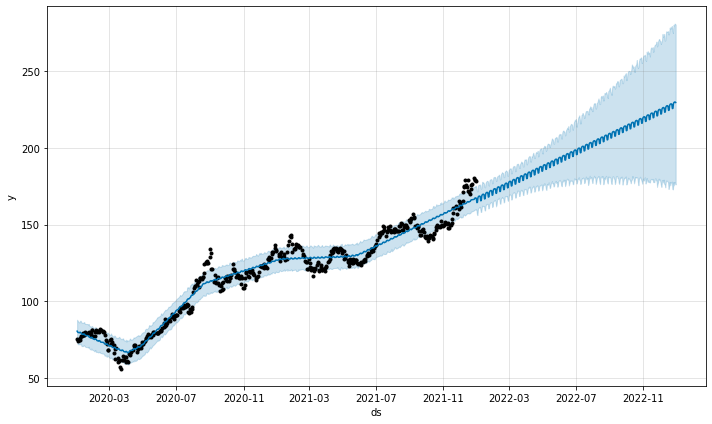

In [17]:
fig1 = m.plot(forecast)

Modelling

In [7]:
import datetime as dt
import json
from typing import List, Optional
import pymongo
from pandas import DataFrame
import pandas as pd

In [3]:
with open('DSCC-FP-MVP-Configuration.JSON') as f:
   configuration = json.load(f)

client = pymongo.MongoClient(configuration['mongo_uri'])
db = client[configuration['database_name']]

In [4]:
def fetch_stock_data_from_db(stock_name: str, start_date: Optional[str] = None, end_date: Optional[str] = None) -> List[object]:
    """Retrieve the stock data from MongoDb collection

    Args:
        stock_name (str): Stock Name
        start_date (Optional[str], optional): Start date to filter records. Defaults to None.
        end_date (Optional[str], optional): End date to filter records. Defaults to None.

    Returns:
        List[object]: List of dictionaries
    """
    if start_date and end_date:
        search_query = {
            "stock": stock_name,
            "Date": {
                '$gte':  dt.datetime.strptime(start_date, '%Y-%m-%d'),
                '$lt': dt.datetime.strptime(end_date, '%Y-%m-%d') + dt.timedelta(1)
            }
        }
    else:
        search_query = {
            "stock": stock_name,
        }
    records = db.stock_price.find(search_query).sort('Date', pymongo.ASCENDING)
    output = [record for record in records]
    return output

In [5]:
stockList = ['AAPL', 'SMSN.IL']

In [11]:
df_ = {}
for i in stockList:
    df_[i] = pd.DataFrame(fetch_stock_data_from_db(i))
    df_[i].set_index("Date", inplace=True)
    df_[i].index = pd.to_datetime(df_[i].index)
df_

{'AAPL':                                  _id        Open        High         Low  \
 Date                                                                       
 2018-01-02  62321305fa9d1ca586e2434b   42.540001   43.075001   42.314999   
 2018-01-03  62321305fa9d1ca586e2434c   43.132500   43.637501   42.990002   
 2018-01-04  62321305fa9d1ca586e2434d   43.134998   43.367500   43.020000   
 2018-01-05  62321305fa9d1ca586e2434e   43.360001   43.842499   43.262501   
 2018-01-08  62321305fa9d1ca586e2434f   43.587502   43.902500   43.482498   
 ...                              ...         ...         ...         ...   
 2021-12-23  620e48e0bc1497d03f99eba3  175.850006  176.850006  175.270004   
 2021-12-27  620e48e0bc1497d03f99eba4  177.089996  180.419998  177.070007   
 2021-12-28  620e48e0bc1497d03f99eba5  180.160004  181.330002  178.529999   
 2021-12-29  620e48e0bc1497d03f99eba6  179.330002  180.630005  178.139999   
 2021-12-30  620e48e0bc1497d03f99eba7  179.470001  180.570007  178.0

In [12]:
for i in stockList:
    print(i, df_[i].shape)

AAPL (1005, 8)
SMSN.IL (1012, 8)
